# Import Libraries 

In [54]:
#Preparing all libraries
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import scipy
from scipy.optimize import curve_fit
from scipy.optimize import golden
from scipy.optimize import fminbound
from scipy.linalg import svd
from scipy.stats import trim_mean
import scipy.io
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
import os

# Options

In [55]:
normalize_data = True
random_start = False
full_plot = False
early_subset = True
introduce_offset = True

imag_opt = False

# Initialize Parameters & Load Data

In [56]:
#Phased is a matrix of 64 TI trials. Each TI trial has 100 noise realizations with 2048 echos

cwd = os.getcwd()

file_oi = "real_phased_dataset" #imag_unphased_dataset    real_unphased_dataset   real_phased_dataset

raw = scipy.io.loadmat(f'{cwd}/{file_oi}.mat')
raw_complex = raw[file_oi]

with open(f'{cwd}/TI_phantom_nullExp.txt') as f:
    TI = f.readlines()

TI_num = [sub.replace("\n", "") for sub in TI]
TI_DATA = [1000*float(elem) for elem in TI_num]# ms/s conversion
assert(TI_DATA[0] < TI_DATA[-1])

TE_DATA = np.arange(1,2048.1,1)*0.4 #ms

sp = 2
ext = 256
if early_subset:
    raw_complex = raw_complex[sp-1::sp,:,:]
    TE_DATA = TE_DATA[sp-1::sp]
    raw_complex = raw_complex[:ext,:,:]
    TE_DATA = TE_DATA[:ext]

raw_real = np.real(raw_complex)
raw_imag = np.imag(raw_complex)

if imag_opt:
    raw_data = raw_imag
else:
    raw_data = raw_real

noise_realizations = raw_data.shape[-1]
assert(len(TI_DATA) == raw_data.shape[1])

print(f"Raw Data has shape {raw_data.shape}")
print(f"TE values = [{TE_DATA[0]}, {TE_DATA[1]}, {TE_DATA[2]}, ..., {TE_DATA[-1]}]")

Raw Data has shape (256, 64, 99)
TE values = [0.8, 1.6, 2.4000000000000004, ..., 204.8]


In [57]:
#Upper will be referred to as the second point
T22 = 39.4 #39.4 +- 0.2 ms
T12 = 317 #317 +- 9 ms
c2 = 0.5

#Upper will be referred to as the first point
T21 = 31.3 #31.3 +- 0.1 ms
T11 = 103.6 #103.6 +- 4 ms
c1 = 0.5

true_params = [T11, T12, c1, c2, T21, T22]

#### Nullpoint Values
TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

ParamTitle_6p = [r'$T_{11}$', r'$T_{12}$', r'$c_1$', r'$c_2$', r'$T_{21}$', r'$T_{22}$']

# Define Functions

In [58]:
def S_biX_6p(TE, T11, T12, c1, c2, T21, T22, TI = 0):
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

def S_biX_4p(TE, d1, d2, T21, T22):
    exp1 = d1*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

#The ravel structure necessary for the curve_fit algorithm
def S_biX_6p_ravel(T_dat, T11, T12, c1, c2, T21, T22):
    TE, TI = T_dat
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2


def get_func_bounds(func):
    f_name = func.__name__
    if f_name == "S_biX_6p":
        lower_bound = (1, 1, 0, 0, 1, 1)
        upper_bound = (500, 500, 1, 1, 150, 150)
    elif f_name == "S_moX_3p":
        lower_bound = (1, 0, 1)
        upper_bound = (500, 1, 150)
    elif f_name == "S_biX_4p":
        lower_bound = (-1, -1, 1, 1)
        upper_bound = (1, 1, 150, 150)
    elif f_name == "S_moX_2p":
        lower_bound = (-1, 1)
        upper_bound = (1, 150)
    else:
        raise Exception("Not a valid function: " + f_name)

    return lower_bound, upper_bound

def get_param_list(func):
    f_name = func.__name__
    if f_name.find("S_biX_6p") > -1:
        params = ("T21","T22","c1","c2","T21","T22")
    elif f_name.find("S_moX_3p") > -1:
        params = ("T21","c","T2")
    else:
        raise Exception("Not a valid function: " + f_name)

    return params

def set_p0(func, random = True):
    # true_params = [T11, T12, c1, c2, T21, T22]
    if random:
        lb, ub = get_func_bounds(func)
        if func.__name__.find("S_biX_6p") > -1:
            T11_est = np.random.uniform(lb[-6],ub[-6])
            T12_est = np.random.uniform(T11_est,ub[-5])
            c1_est = np.random.uniform(lb[-4],ub[-4])
            T21_est = np.random.uniform(lb[-2],ub[-2])
            T22_est = np.random.uniform(T21_est,ub[-1])
            p0 = [T11_est, T12_est, c1_est, 1-c1_est, T21_est, T22_est]
        else:
            p0 = [np.random.uniform(lb[i],ub[i]) for i in range(len(lb))]
    else:
        p0 = true_params
            
    return p0



def det_normFactor(noisy_curve):

    lb = (0, 0, 0, 0)
    ub = (np.inf, np.inf, 150, 150)

    d_init = 0.5*noisy_curve[0]

    popt, _, _, _, _ = curve_fit(S_biX_4p, TE_DATA, noisy_curve, p0 = (d_init, d_init, 30, 50), bounds = [lb,ub], method = 'trf', maxfev = 1500, full_output=True)

    return popt[0]+popt[1]

def d_value(TI,c,T1):
    return c*(1-2*np.exp(-TI/T1))

In [59]:
def calc_MSE(iteration_param_values, true_p):

    bias_values = np.mean(iteration_param_values - true_p, axis = 0)
    std_values = np.std(iteration_param_values, axis = 0)
    MSE_values = std_values**2 + bias_values

    return bias_values, std_values, MSE_values

def calc_SNR(noisy_curve):
    return noisy_curve[0]/np.mean(noisy_curve[-3:])


# Initial Visualization

(0.0, 300.0)

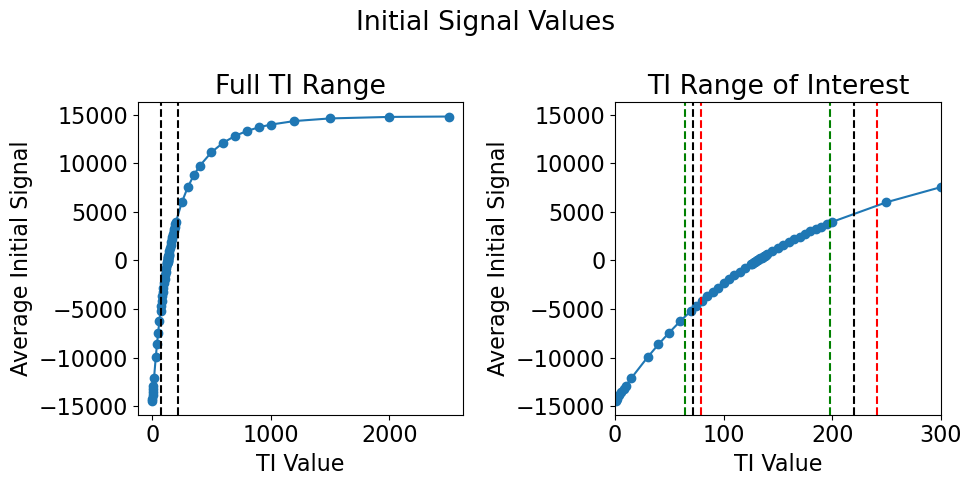

In [60]:
plt.rc('font', size = 16)
fig, ax = plt.subplots(1,2, figsize = (10, 5), tight_layout=True)

fig.suptitle(f"Initial Signal Values")

ax[0].set_title("Full TI Range")
ax[0].plot(TI_DATA, np.mean(raw_data[0,:,:], axis = -1), marker = 'o')

ax[0].set_ylabel("Average Initial Signal")
ax[0].set_xlabel("TI Value")

ax[0].axvline(x = TI1star, ls = '--', color = 'k')
ax[0].axvline(x = TI2star, ls = '--', color = 'k')
# fig.legend(loc = 'center left', bbox_to_anchor = (1.02,0.4))

ax[1].set_title("TI Range of Interest")
ax[1].plot(TI_DATA, np.mean(raw_data[0,:,:], axis = -1), marker = 'o')

ax[1].set_ylabel("Average Initial Signal")
ax[1].set_xlabel("TI Value")

ax[1].axvline(x = TI1star, ls = '--', color = 'k')
ax[1].axvline(x = TI2star, ls = '--', color = 'k')

ax[1].axvline(x = 0.9*TI1star, ls = '--', color = 'g')
ax[1].axvline(x = 0.9*TI2star, ls = '--', color = 'g')

ax[1].axvline(x = 1.1*TI1star, ls = '--', color = 'r')
ax[1].axvline(x = 1.1*TI2star, ls = '--', color = 'r')


ax[1].set_xlim([0,300])

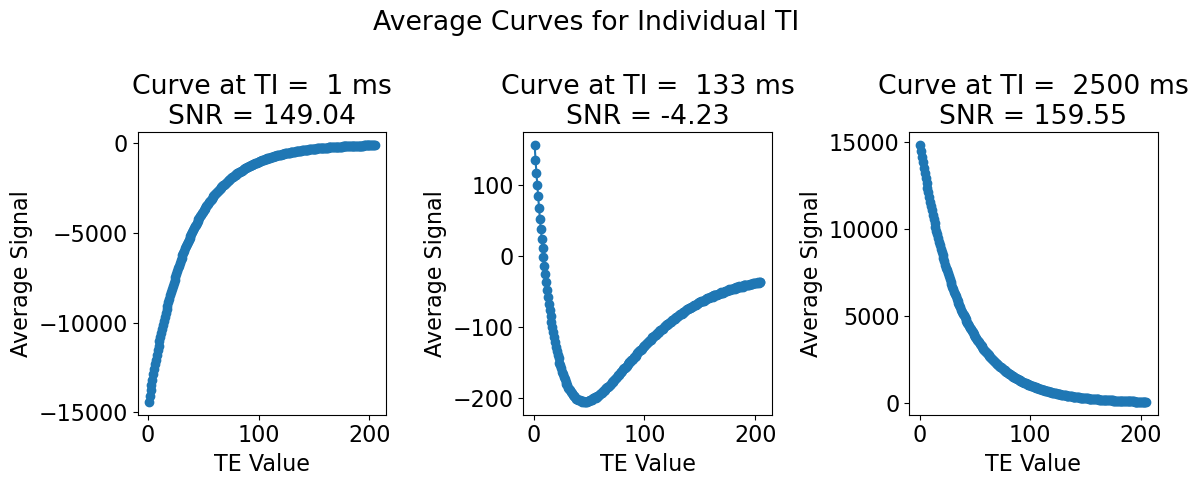

In [62]:
indices = [0,30,-1]

plt.rc('font', size = 16)
fig, ax = plt.subplots(1,3, figsize = (12, 5), tight_layout=True)

fig.suptitle(f"Average Curves for Individual TI")

for i in range(len(indices)):
    index_oi = indices[i]
    ax[i].set_title(f"Curve at TI = {TI_DATA[index_oi]: .0f} ms")
    ax[i].plot(TE_DATA, np.mean(raw_data[:,index_oi,:], axis = -1), marker = 'o')

    ax[i].set_ylabel("Average Signal")
    ax[i].set_xlabel("TE Value")


# Checking Curve Shape with Model

Text(0.5, 0, 'TE Value')

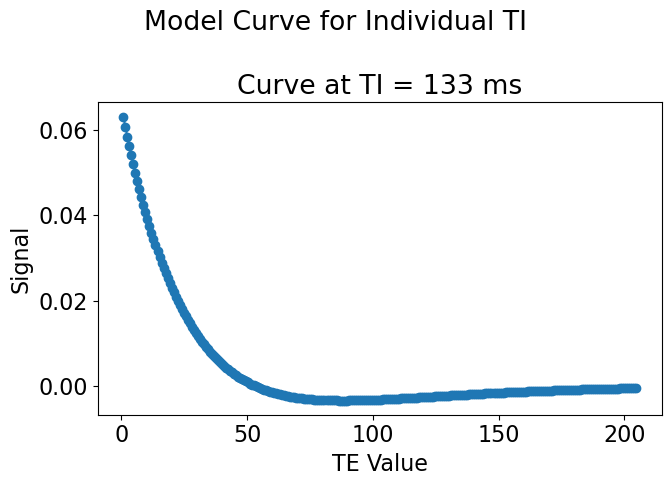

In [ ]:
TI_funky = 133

data_temp = S_biX_6p(TE_DATA, *true_params, TI = TI_funky)

plt.rc('font', size = 16)
fig, ax = plt.subplots(1,1, figsize = (7, 5), tight_layout=True)

fig.suptitle(f"Model Curve for Individual TI")

ax.set_title(f"Curve at TI = {TI_funky} ms")
ax.plot(TE_DATA, data_temp, marker = 'o')

ax.set_ylabel("Signal")
ax.set_xlabel("TE Value")

# SNR Calculation

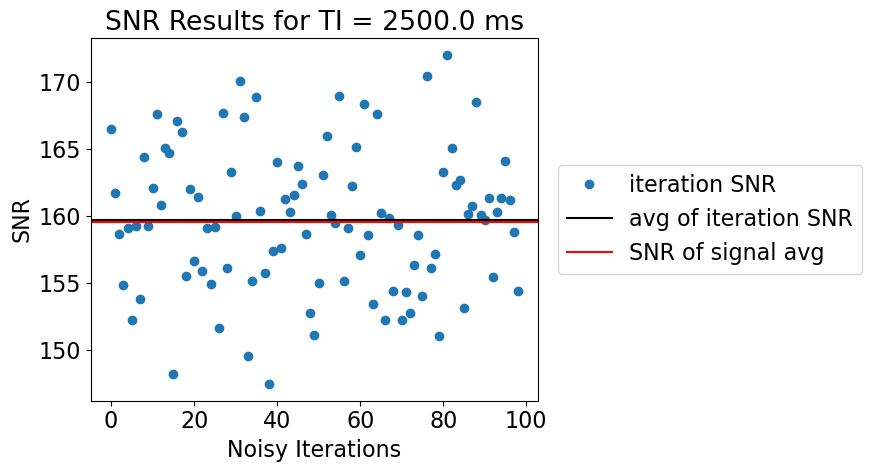

In [68]:
iterSNR = [calc_SNR(raw_data[:,-1,i]) for i in range(raw_data.shape[-1])]
avgSNR = calc_SNR(np.mean(raw_data[:,-1,:], axis = -1))

fig, ax = plt.subplots(1,1, figsize = (9, 5), tight_layout=True)

ax.set_title(f"SNR Results for TI = {TI_funky} ms")
ax.plot(range(raw_data.shape[-1]), iterSNR, marker = 'o', ls = '', label = "iteration SNR")
ax.axhline(y = np.mean(iterSNR), color = 'k', label = 'avg of iteration SNR')
ax.axhline(y = avgSNR, color = 'r', label = 'SNR of signal avg')

ax.set_ylabel("SNR")
ax.set_xlabel("Noisy Iterations")

ax.legend(loc = 'center left', bbox_to_anchor = (1.02,0.5))

# Preprocessing

In [ ]:
if normalize_data:
    norm_factor = det_normFactor(np.mean(raw_data[:,-1,:], axis = -1))
    normed_data = raw_data/norm_factor
    print(f"All data has been normalized by the normalization factor value of {norm_factor: 0.2f}")
else:
    print("No Normalization")

All data has been normalized by the normalization factor value of  15090.20


# Estimating

In [ ]:
mTE, mTI = np.meshgrid(TE_DATA, TI_DATA)
vecT = np.vstack((mTE.ravel(), mTI.ravel()))

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')

surf = ax.plot_surface(mTI, mTE, imag_diff, cmap = plt.cm.jet, linewidth=0, antialiased=False)

ax.set_title('Absolute Normalized Imaginary Diff to Simulation')
ax.set_xlabel('Inversion Times')
ax.set_ylabel('Echo Times')
plt.show()

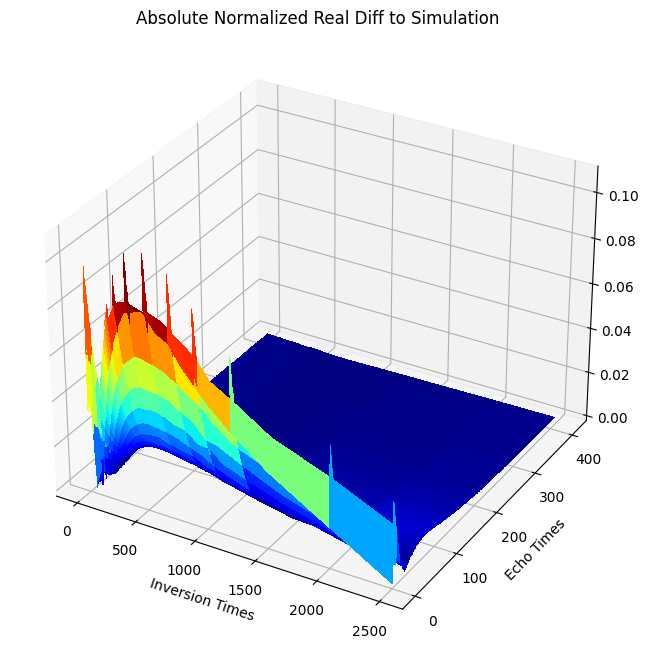

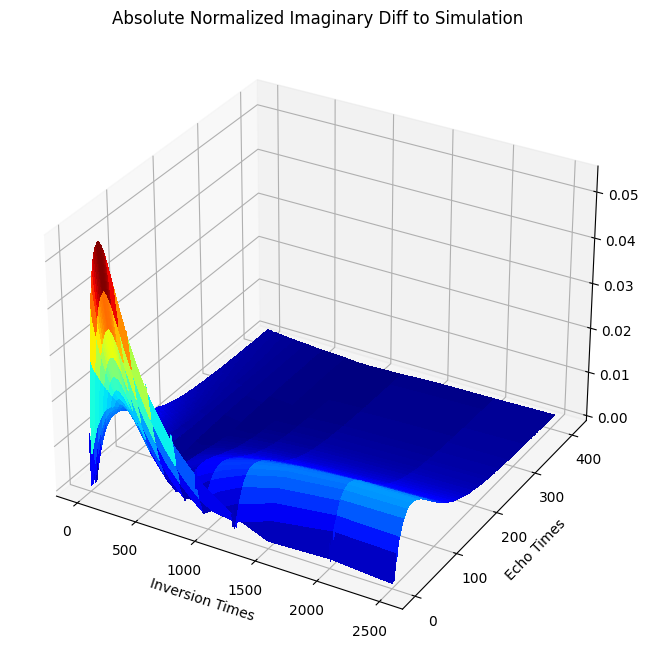

In [ ]:
sim_norm = normalize(signal_mat)
real_norm = normalize(average_real_signal)
imag_norm = normalize(average_imag_signal)

real_diff = np.abs(sim_norm + real_norm)
imag_diff = np.abs(sim_norm - imag_norm)

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')

surf = ax.plot_surface(mTI, mTE, real_diff, cmap = plt.cm.jet, linewidth=0, antialiased=False)

ax.set_title('Absolute Normalized Real Diff to Simulation')
ax.set_xlabel('Inversion Times')
ax.set_ylabel('Echo Times')
plt.show()

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')

surf = ax.plot_surface(mTI, mTE, imag_diff, cmap = plt.cm.jet, linewidth=0, antialiased=False)

ax.set_title('Absolute Normalized Imaginary Diff to Simulation')
ax.set_xlabel('Inversion Times')
ax.set_ylabel('Echo Times')
plt.show()

# Parameter Fitting

In [ ]:
param_array_4p = np.zeros((len(TI_array),noise_realizations,5))
param_array_2p = np.zeros((len(TI_array),noise_realizations,3))
RSS_4p = np.zeros((len(TI_array),noise_realizations))
RSS_2p = np.zeros((len(TI_array),noise_realizations))
std_array_4p = np.zeros((len(TI_array),4))
std_array_2p = np.zeros((len(TI_array),2))
for iTI in trange(len(TI_array)):
    TI_oi = TI_array[iTI]
    data_TI = raw_data[:,iTI,:]
    data_TI_order= np.transpose(data_TI)
    param_array_4p[iTI,:,:], RSS_4p[iTI,:] = estimate_params(TI_oi, TE_sequence, data_TI_order, S_biX_4p)
    param_array_2p[iTI,:,:], RSS_2p[iTI,:] = estimate_params(TI_oi, TE_sequence, data_TI_order, S_moX_2p)
    std_array_4p[iTI,:] = calc_std(param_array_4p[iTI,:,:],[0,1,2,3])
    std_array_2p[iTI,:] = calc_std(param_array_2p[iTI,:,:],[0,1])

100%|██████████| 64/64 [04:49<00:00,  4.52s/it]


# Present Results

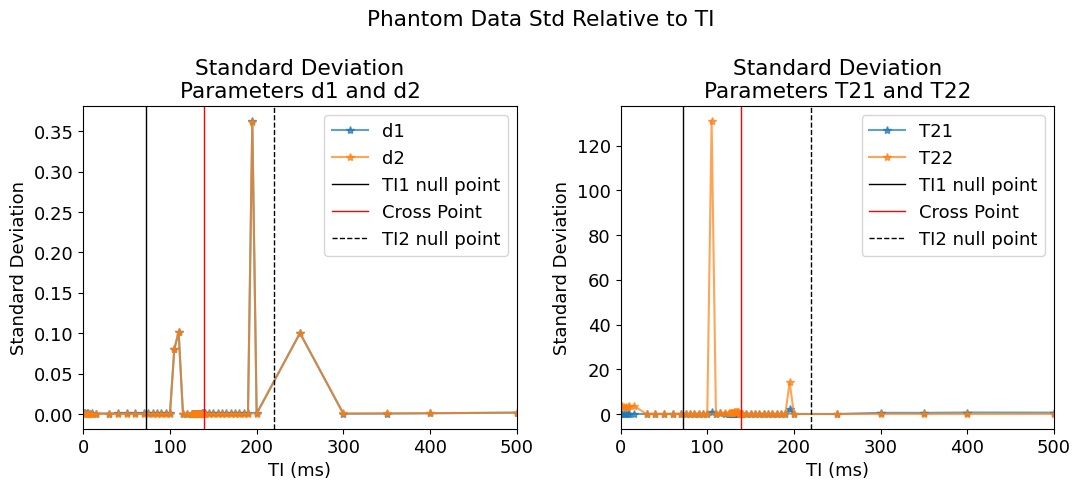

In [ ]:
estParams = get_param_list(S_biX_4p)

plt.rc('font', size = 13)
fig, ax = plt.subplots(1,2, figsize=(11,5), tight_layout=True)
fig.suptitle('Phantom Data Std Relative to TI')
for i in range(2):
    ax[i].plot(TI_array, std_array_4p[:,2*i], label = estParams[2*i], alpha = 0.7, marker = '*')
    ax[i].plot(TI_array, std_array_4p[:,2*i+1], label = estParams[2*i+1], alpha = 0.7, marker = '*')
    # ax[i].plot(TI_array,mono_std[:,i], label = MonoTitle[i], alpha = 0.7)
    ax[i].axvline(x=TI1star, linewidth=1, label= r'TI1 null point', color='k')
    ax[i].axvline(x=139, linewidth=1, label= r'Cross Point', color='r')
    ax[i].axvline(x=TI2star, linewidth=1, label= r'TI2 null point', color='k', ls = '--')
    ax[i].set_xlabel('TI (ms)')
    ax[i].set_ylabel('Standard Deviation')
    ax[i].set_title('Standard Deviation' + '\nParameters ' + estParams[2*i] + ' and ' + estParams[2*i+1])
    ax[i].legend()
    ax[i].set_xlim([0,500])
plt.show()

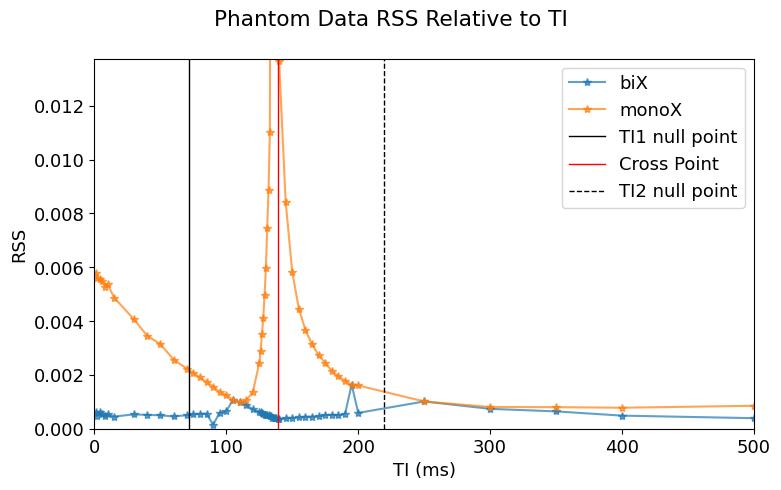

In [ ]:
avgRSS_4p = np.mean(RSS_4p, axis = -1)
avgRSS_2p = np.mean(RSS_2p, axis = -1)

plt.rc('font', size = 13)
fig, ax = plt.subplots(1,1, figsize=(8,5), tight_layout=True)
fig.suptitle('Phantom Data RSS Relative to TI')
for i in range(1):
    ax.plot(TI_array, RSS_4p[:,1], label = "biX", alpha = 0.7, marker = '*')
    ax.plot(TI_array, RSS_2p[:,1], label = "monoX", alpha = 0.7, marker = '*')
    ax.axvline(x=TI1star, linewidth=1, label= r'TI1 null point', color='k')
    ax.axvline(x=139, linewidth=1, label= r'Cross Point', color='r')
    ax.axvline(x=TI2star, linewidth=1, label= r'TI2 null point', color='k', ls = '--')
    ax.set_xlabel('TI (ms)')
    ax.set_ylabel('RSS')
    # ax[i].set_title('' + '\nParameters ' + estParams[2*i] + ' and ' + estParams[2*i+1])
    ax.legend()
    ax.set_xlim([0,500])
    ax.set_ylim([0,np.min([np.min(RSS_4p),np.min(RSS_2p)])*100])
plt.show()

In [ ]:
if full_plot:
    for k in range(param_array_4p.shape[0]):
        paramData = param_array_4p[k,:,:].copy()
        estParams = get_param_list(S_biX_4p)
        fig, ax = plt.subplots(2,2, figsize=(9.5,9.5), tight_layout=True)
        TI = TI_array[k]
        fig.suptitle("Parameter Histogram" + '\n'+ r'$\alpha_1$'+ ' = ' + "{:.3f} :: ".format(TI/TI1star) + r'$\alpha_2$'+ ' = ' + "{:.3f} ".format(TI/TI2star) + ' :: TI = ' + str(round(TI,2)))

        

        true_d1 = d_value(T1low, 0.5*max_sig_mag, TI)
        true_d2 = d_value(T1up, 0.5*max_sig_mag, TI)
        plotParams = (true_d1, true_d2, T2low, T2up)
        
        for ii in range(len(estParams)):
            #Construct a nice figure of each of the two 
            color_opt = ["b","g"][ii%2]
            ax[ii//2,ii%2].hist(x=paramData[:,ii], bins=10, color=color_opt, label = estParams[ii], alpha = 0.7)
            # ax[ii].hist(x=paramData[:,2*ii+1], bins=20, color='g', label = estParams[2*ii+1], alpha = 0.7)
            ax[ii//2,ii%2].set_xlabel('Param Value')
            ax[ii//2,ii%2].set_ylabel('Count')
            # ax[ii//2,ii%2].axvline(x=plotParams[ii], linewidth=1, label= 'True ' + estParams[ii], color='b')
            # ax[ii].axvline(x=plotParams[2*ii+1], linewidth=1, label= 'True ' + estParams[2*ii+1], color='g')
            ax[ii//2,ii%2].axvline(x=np.mean(paramData[:,ii]), linewidth=1, label= 'Avg ' + estParams[ii], color=color_opt, ls = "--")
            # ax[ii].axvline(x=np.mean(paramData[:,2*ii+1]), linewidth=1, label= 'Avg ' + estParams[2*ii+1], color='g', ls = "--")
            ax[ii//2,ii%2].legend()
            ax[ii//2,ii%2].set_title('Parameter Histogram' +
                        '\nTheroetical True ' + estParams[ii] + '=' + str(round(plotParams[ii],2)))
        plt.show()

In [ ]:
if full_plot:
    for k in range(param_array_4p.shape[0]):

        TI = TI_array[k]

        fig, ax = plt.subplots(1,2, figsize=(7,4), tight_layout=True)

        fig.suptitle('Fit Visualization' + '\n' + r'$\alpha_1$'+ ' = ' + "{:.3f} :: ".format(TI/TI1star) + r'$\alpha_2$'+ ' = ' + "{:.3f} ".format(TI/TI2star) + ' :: TI = ' + str(round(TI,2)))
        
        for rep in range(noise_realizations):
            ax[0].plot(TE_sequence, S_biX_4p(TE_sequence, *param_array_4p[k,rep,:]), color='r', alpha = 0.5)
            ax[1].plot(TE_sequence, S_moX_2p(TE_sequence, *param_array_2p[k,rep,:]), color='r', alpha = 0.5)

        ax[0].plot(TE_sequence, average_signal[k,:], label = "True Data", color='k', alpha = 1)
        ax[1].plot(TE_sequence, average_signal[k,:], label = "True Data", color='k', alpha = 1)

        ax[0].set_xlabel("TE")
        ax[1].set_xlabel("TE")
        ax[0].set_ylabel("Signal")
        ax[1].set_ylabel("Signal")
        ax[0].set_title("Biexponential Fits")
        ax[1].set_title("Monoexponential Fits")

        plt.show()

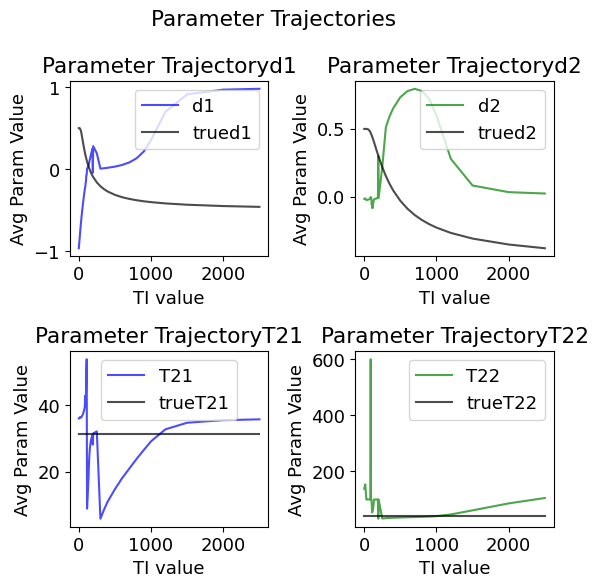

In [ ]:
avg_params = np.mean(param_array_4p, axis = 1)
estParams = get_param_list(S_biX_4p)
fig, ax = plt.subplots(2,2, figsize=(6,6), tight_layout=True)
fig.suptitle("Parameter Trajectories")

true_d1_array = []
true_d2_array = []
for TI in TI_array:
    true_d1_array.append(d_value(T1low, 0.5*max_sig_mag, TI))
    true_d2_array.append(d_value(T1up, 0.5*max_sig_mag, TI))
true_T21_array = np.ones(len(TI_array))*T2low
true_T22_array = np.ones(len(TI_array))*T2up
true_array = [true_d1_array, true_d2_array, true_T21_array, true_T22_array]

for ii in range(4):
    #Construct a nice figure of each of the two 
    color_opt = ["b","g"][ii%2]
    ax[ii//2,ii%2].plot(TI_array, avg_params[:,ii], color=color_opt, label = estParams[ii], alpha = 0.7)
    ax[ii//2,ii%2].plot(TI_array, true_array[ii], color="black", label = "true" + estParams[ii], alpha = 0.7)
    ax[ii//2,ii%2].set_xlabel('TI value')
    ax[ii//2,ii%2].set_ylabel('Avg Param Value')
    ax[ii//2,ii%2].legend()
    ax[ii//2,ii%2].set_title('Parameter Trajectory' + estParams[ii])
plt.show()

# Single Curve Testing

In [ ]:
TI_oi = 22
rep_oi = 10
curve_oi = raw_data[:,TI_oi,rep_oi]
func_oi = S_biX_4p

start_val, param_val, RSS_val = start_surface(TE_sequence, curve_oi, func_oi, 1000, True)
lbound_oi, ubound_oi = get_func_bounds(func_oi)
estParams = get_param_list(func_oi)

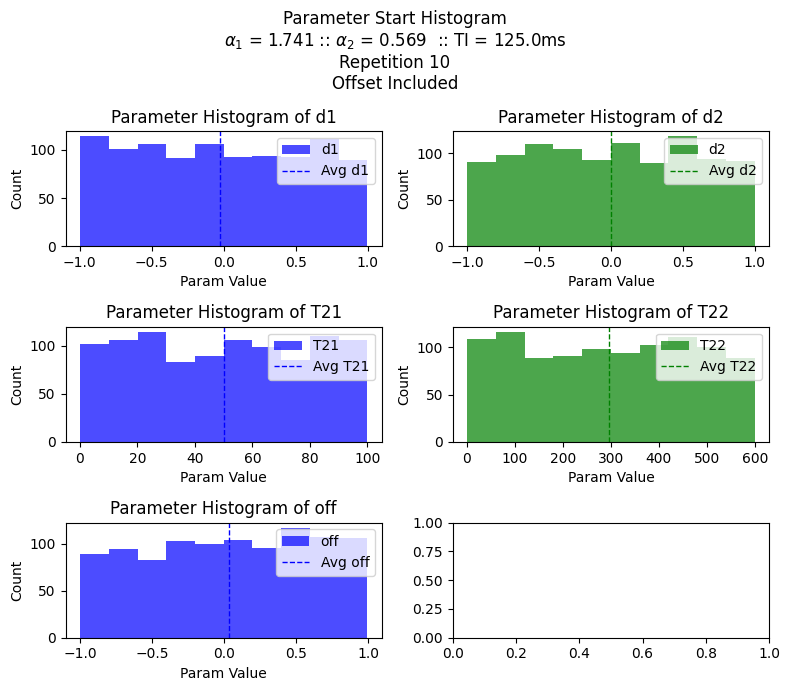

In [ ]:
plt.rc('font', size = 10)

fig, ax = plt.subplots(int(np.ceil(len(lbound_oi)/2)),2, figsize=(8,7), tight_layout=True)

fig.suptitle("Parameter Start Histogram" 
+ '\n'+ r'$\alpha_1$'+ ' = ' + "{:.3f} :: ".format(TI_array[TI_oi]/TI1star) 
+ r'$\alpha_2$'+ ' = ' + "{:.3f} ".format(TI_array[TI_oi]/TI2star) 
+ ' :: TI = ' + str(round(TI_array[TI_oi],2)) + "ms" 
+ f'\nRepetition {rep_oi}' + offset_blurb)

for ii in range(len(lbound_oi)):
    #Construct a nice figure of each of the two 
    color_opt = ["b","g"][ii%2]
    ax[ii//2,ii%2].hist(x=start_val[:,ii], bins=10, color=color_opt, label = estParams[ii], alpha = 0.7)
    ax[ii//2,ii%2].set_xlabel('Param Value')
    ax[ii//2,ii%2].set_ylabel('Count')
    ax[ii//2,ii%2].axvline(x=np.mean(start_val[:,ii]), linewidth=1, label= 'Avg ' + estParams[ii], color=color_opt, ls = "--")
    ax[ii//2,ii%2].legend()
    ax[ii//2,ii%2].set_title('Parameter Histogram of ' + estParams[ii])
plt.show()

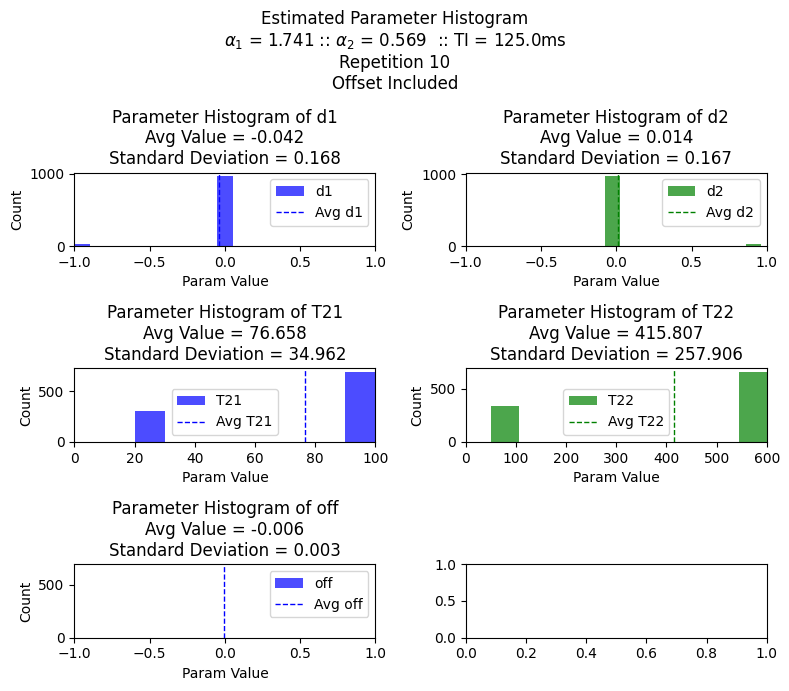

In [ ]:
plt.rc('font', size = 10)

fig, ax = plt.subplots(int(np.ceil(len(lbound_oi)/2)),2, figsize=(8,7), tight_layout=True)

fig.suptitle("Estimated Parameter Histogram" 
+ '\n'+ r'$\alpha_1$'+ ' = ' + "{:.3f} :: ".format(TI_array[TI_oi]/TI1star) 
+ r'$\alpha_2$'+ ' = ' + "{:.3f} ".format(TI_array[TI_oi]/TI2star) 
+ ' :: TI = ' + str(round(TI_array[TI_oi],2)) + "ms" 
+ f'\nRepetition {rep_oi}' + offset_blurb)

for ii in range(len(lbound_oi)):
    #Construct a nice figure of each of the two 
    color_opt = ["b","g"][ii%2]
    ax[ii//2,ii%2].hist(x=param_val[:,ii], bins=10, color=color_opt, label = estParams[ii], alpha = 0.7)
    ax[ii//2,ii%2].set_xlabel('Param Value')
    ax[ii//2,ii%2].set_ylabel('Count')
    ax[ii//2,ii%2].axvline(x=np.mean(param_val[:,ii]), linewidth=1, label= 'Avg ' + estParams[ii], color=color_opt, ls = "--")
    ax[ii//2,ii%2].legend()
    ax[ii//2,ii%2].set_xlim([lbound_oi[ii], ubound_oi[ii]])
    ax[ii//2,ii%2].set_title('Parameter Histogram of ' + estParams[ii] 
            + f'\nAvg Value = {np.round(np.mean(param_val[:,ii]),3)}'
            + f'\nStandard Deviation = {np.round(np.std(param_val[:,ii]),3)}')
plt.show()

In [ ]:
T21_outlier_index = np.where(complete_estimates[pC_index,0,:,lambda_oi,2]<pCombo_oi[2]//2)

plt.rc('font', size = 10)
fig, ax = plt.subplots(1, 2, figsize=(9,5), tight_layout=True)
fig.suptitle(str(pCombo_oi) + ' :: SNR = ' + str(SNR[0]) + f"\nParameter Estimate Distribution at GCV lambda = {np.round(lambdas[lambda_oi],5)}" + post_norm_blurb)
ax[0].plot(T21_outlier_index, param_val[:,ii], color = "green", alpha = 0.5, ls = '', marker = 'o', markersize = 5)
ax[0].plot(T21_outlier_index, complete_estimates[pC_index,0,T21_outlier_index,lambda_oi,1], color = "green", alpha = 0.5, ls = '', marker = 'o', markersize = 5)
ax[0].plot(complete_estimates[pC_index,0,:,lambda_oi,0], color = "red", label = "c1", alpha = 0.4, ls = '', marker = '.')
ax[0].axhline(y = pCombo_oi[0], label = 'true c1', color = "red", alpha = 0.4)
ax[0].plot(complete_estimates[pC_index,0,:,lambda_oi,1], color = "blue", label = "c2", alpha = 0.4, ls = '', marker = '.')
ax[0].axhline(y = pCombo_oi[1], label = 'true c2', color = "blue", alpha = 0.4)
ax[0].set_xlabel("Noise Realization")
ax[0].set_ylabel("Param Value")
ax[0].legend()

ax[1].plot(T21_outlier_index, complete_estimates[pC_index,0,T21_outlier_index,lambda_oi,2], color = "green", alpha = 0.5, ls = '', marker = 'o', markersize = 5)
ax[1].plot(T21_outlier_index, complete_estimates[pC_index,0,T21_outlier_index,lambda_oi,3], color = "green", alpha = 0.5, ls = '', marker = 'o', markersize = 5)
ax[1].plot(complete_estimates[pC_index,0,:,lambda_oi,2], color = "red", label = "T21", alpha = 0.4, ls = '', marker = '.')
ax[1].axhline(y = pCombo_oi[2], label = 'true T21', color = "red", alpha = 0.4)
ax[1].plot(complete_estimates[pC_index,0,:,lambda_oi,3], color = "blue", label = "T22", alpha = 0.4, ls = '', marker = '.')
ax[1].axhline(y = pCombo_oi[3], label = 'true T22', color = "blue", alpha = 0.4)
ax[1].set_xlabel("Noise Realization")
ax[1].set_ylabel("Param Value")
ax[1].legend()

In [ ]:
d1_expected = d_value(TI_array[TI_oi], 0.5, T1low)
print(f'Expected d1 {d1_expected}')

d2_expected = d_value(TI_array[TI_oi], 0.5, T2low)
print(f'Expected d2 {d2_expected}')

Expected d1 0.2007762646242145
Expected d1 0.4815669535704232


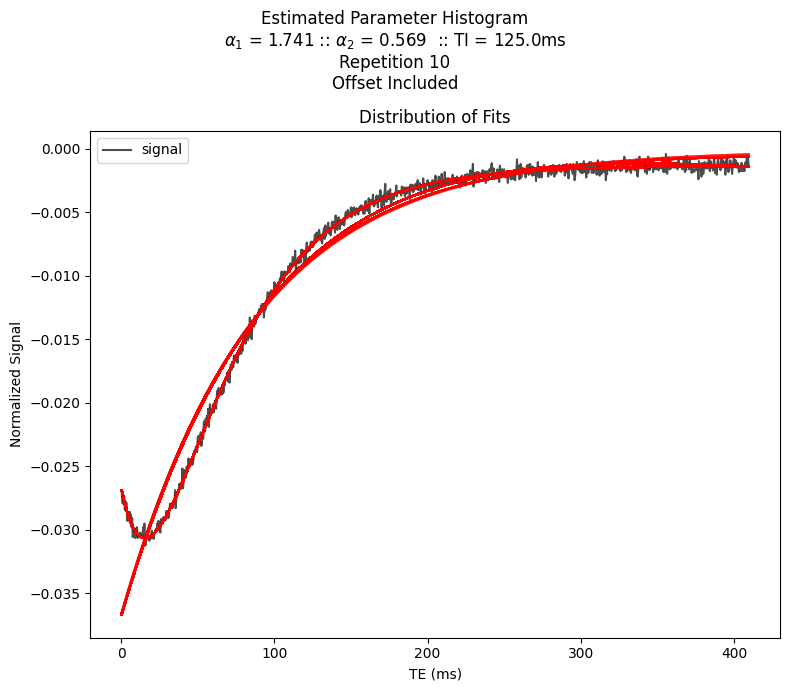

In [ ]:
plt.rc('font', size = 10)

fig, ax = plt.subplots(1,1, figsize=(8,7), tight_layout=True)

fig.suptitle("Estimated Parameter Histogram" 
+ '\n'+ r'$\alpha_1$'+ ' = ' + "{:.3f} :: ".format(TI_array[TI_oi]/TI1star) 
+ r'$\alpha_2$'+ ' = ' + "{:.3f} ".format(TI_array[TI_oi]/TI2star) 
+ ' :: TI = ' + str(round(TI_array[TI_oi],2)) + "ms" 
+ f'\nRepetition {rep_oi}' + offset_blurb)

ax.plot(TE_sequence, curve_oi, color="black", label = "signal", alpha = 0.7)
ax.set_xlabel('TE (ms)')
if normalize_data:
    ax.set_ylabel('Normalized Signal')
else:
    ax.set_ylabel('Signal')
    
for ii in range(param_val.shape[0]):
    ax.plot(TE_sequence, func_oi(TE_sequence, *param_val[ii,:]), color = "red", alpha = 0.4, ls = "-")

ax.legend()
ax.set_title('Distribution of Fits')
plt.show()

### Per Curve Collected Results

In [ ]:
best_start_collection_biX = np.zeros((raw_data.shape[1],raw_data.shape[2],5))
best_start_collection_moX = np.zeros((raw_data.shape[1],raw_data.shape[2],3))

iters = 1000

for iTI in trange(raw_data.shape[1]):
    for iRep in range(raw_data.shape[2]):
        curve_oi = raw_data[:,iTI,iRep]

        _, param_val, _ = start_surface(TE_sequence, curve_oi, S_biX_4p, iters, True)

        best_start_collection_biX[iTI,iRep,:] = np.mean(param_val, axis = 0)

        _, param_val, _ = start_surface(TE_sequence, curve_oi, S_moX_2p, iters, True)

        best_start_collection_moX[iTI,iRep,:] = np.mean(param_val, axis = 0)

  0%|          | 0/64 [00:31<?, ?it/s]


KeyboardInterrupt: 